Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [39]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [40]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [41]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [42]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Logistic regression 
--------

In [43]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
batch_size = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.placeholder(tf.float32, [batch_size, image_size * image_size])
  tf_train_labels = tf.placeholder(tf.float32, [batch_size, num_labels])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_regularisation_beta = tf.placeholder(tf.float32)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits)) + \
        tf_regularisation_beta*tf.nn.l2_loss(weights)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Plotting the accuracy using several values of Beta

Initialized


Text(0, 0.5, 'test accuracy')

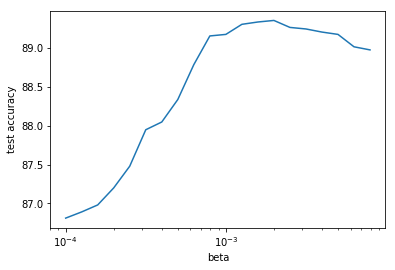

In [44]:
num_steps = 3001

regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_vals = []
print('Initialized')
for beta in regul_val: 
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_regularisation_beta: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        accuracy_vals.append(test_accuracy)

plt.semilogx(regul_val, accuracy_vals)          
plt.xlabel('beta')
plt.ylabel('test accuracy')
# plt.legend()

In [45]:
num_steps = 3001

print('Initialized')
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_regularisation_beta: 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))





Initialized
Loss at step 0: 20.088163
Training accuracy: 9.0%
Validation accuracy: 11.8%
Loss at step 500: 2.702981
Training accuracy: 76.6%
Validation accuracy: 76.4%
Loss at step 1000: 1.682336
Training accuracy: 78.5%
Validation accuracy: 79.2%
Loss at step 1500: 1.159061
Training accuracy: 81.4%
Validation accuracy: 80.9%
Loss at step 2000: 0.920835
Training accuracy: 81.8%
Validation accuracy: 82.0%
Loss at step 2500: 0.790443
Training accuracy: 82.9%
Validation accuracy: 82.7%
Loss at step 3000: 0.709097
Training accuracy: 83.4%
Validation accuracy: 82.9%
Test accuracy: 89.1%


In [46]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_regularisation_beta: 1e-2}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 44.246143
Minibatch accuracy: 8.9%
Validation accuracy: 12.2%
Minibatch loss at step 500: 0.862647
Minibatch accuracy: 82.6%
Validation accuracy: 82.7%
Minibatch loss at step 1000: 0.734559
Minibatch accuracy: 82.3%
Validation accuracy: 83.0%
Minibatch loss at step 1500: 0.724856
Minibatch accuracy: 82.7%
Validation accuracy: 82.8%
Minibatch loss at step 2000: 0.721846
Minibatch accuracy: 82.7%
Validation accuracy: 82.9%
Minibatch loss at step 2500: 0.720554
Minibatch accuracy: 82.7%
Validation accuracy: 82.8%
Minibatch loss at step 3000: 0.708209
Minibatch accuracy: 83.0%
Validation accuracy: 82.9%
Test accuracy: 88.8%


Neural network
--------

#### light version 


In [47]:
batch_size = 128
hidden_layers_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_regularisation_beta = tf.placeholder(tf.float32)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.relu(logit_hidden), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)) \
            + tf_regularisation_beta*tf.nn.l2_loss(weights) + tf_regularisation_beta*tf.nn.l2_loss(hidden_weights) 

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)


Initialized


Text(0, 0.5, 'test accuracy')

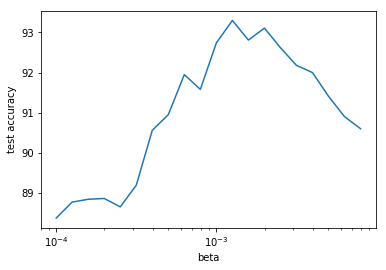

In [48]:
num_steps = 3001

regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_vals = []
print('Initialized')
for beta in regul_val: 
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_regularisation_beta: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        accuracy_vals.append(test_accuracy)

plt.semilogx(regul_val, accuracy_vals)          
plt.xlabel('beta')
plt.ylabel('test accuracy')
# plt.legend()

In [49]:
beta = regul_val[accuracy_vals.index(max(accuracy_vals))]
print(beta)

0.00125892541179417


In [50]:
num_steps = 3001
beta = 0.00158

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_regularisation_beta: beta}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 862.159546
Minibatch accuracy: 5.5%
Validation accuracy: 38.7%
Minibatch loss at step 500: 229.924805
Minibatch accuracy: 85.2%
Validation accuracy: 79.6%
Minibatch loss at step 1000: 100.234222
Minibatch accuracy: 84.4%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 46.895138
Minibatch accuracy: 76.6%
Validation accuracy: 81.3%
Minibatch loss at step 2000: 20.832012
Minibatch accuracy: 89.8%
Validation accuracy: 86.6%
Minibatch loss at step 2500: 9.744510
Minibatch accuracy: 83.6%
Validation accuracy: 87.1%
Minibatch loss at step 3000: 4.695959
Minibatch accuracy: 89.1%
Validation accuracy: 87.7%
Test accuracy: 93.1%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [51]:
print(train_dataset.shape)
print(train_labels.shape)
train_dataset1 = train_dataset[:256, :]
train_labels1 = train_labels[:256, :]
print(train_dataset1.shape)
print(train_labels.shape)


batch_size = 128
hidden_layers_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.relu(logit_hidden), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)) 
#             + 0.01*tf.nn.l2_loss(weights) + 0.01*tf.nn.l2_loss(hidden_weights) 

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)

    
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels1.shape[0] - batch_size)

        # Generate a minibatch.
        batch_data = train_dataset1[offset:(offset + batch_size), :]
        batch_labels = train_labels1[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

(200000, 784)
(200000, 10)
(256, 784)
(200000, 10)
Initialized
Minibatch loss at step 0: 351.815063
Minibatch accuracy: 10.2%
Validation accuracy: 36.8%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Test accuracy: 70.9%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [52]:
print(train_dataset.shape)
print(train_labels.shape)
train_dataset1 = train_dataset[:256, :]
train_labels1 = train_labels[:256, :]
print(train_dataset1.shape)
print(train_labels.shape)


batch_size = 128
hidden_layers_size = 1024
dropout_keep_prob = 0.6

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_dropout_keep_prob = tf.placeholder(tf.float32)
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.dropout(tf.nn.relu(logit_hidden), tf_dropout_keep_prob), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)

(200000, 784)
(200000, 10)
(256, 784)
(200000, 10)


Initialized


Text(0, 0.5, 'test accuracy')

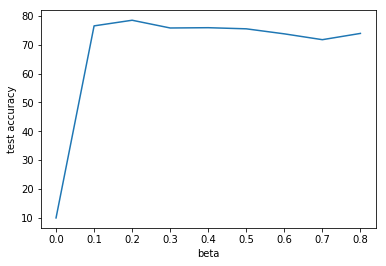

In [53]:
num_steps = 3001
accuracy_vals = []
dropout_keep_prob_vals = np.arange(0.0, 0.9, 0.1)
print("Initialized")
for dropout in dropout_keep_prob_vals: 
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels1.shape[0] - batch_size)

            # Generate a minibatch.
            batch_data = train_dataset1[offset:(offset + batch_size), :]
            batch_labels = train_labels1[offset:(offset + batch_size), :]

            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_dropout_keep_prob: dropout}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        accuracy_vals.append(test_accuracy)

# plt.semilogx(dropout_keep_prob_vals, accuracy_vals)    
plt.plot(dropout_keep_prob_vals, accuracy_vals)
plt.xlabel('beta')
plt.ylabel('test accuracy')
# plt.legend()

In [54]:
beta = dropout_keep_prob_vals[accuracy_vals.index(max(accuracy_vals))]
print(beta)

0.2


In [55]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels1.shape[0] - batch_size)

        # Generate a minibatch.
        batch_data = train_dataset1[offset:(offset + batch_size), :]
        batch_labels = train_labels1[offset:(offset + batch_size), :]

        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_dropout_keep_prob:0.2}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 817.704224
Minibatch accuracy: 7.8%
Validation accuracy: 33.4%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 68.9%
Minibatch loss at step 1000: 1.820763
Minibatch accuracy: 98.4%
Validation accuracy: 69.5%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 70.2%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.9%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 69.7%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 70.1%
Test accuracy: 76.5%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [78]:
import math 

batch_size = 128
hidden_layers_size = 1024
learning_starting_rate = 0.5
learning_decay_steps = 1000
learning_decay_rate = 0.95

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_regularisation_beta = tf.placeholder(tf.float32)
    tf_decay_rate = tf.placeholder(tf.float32)
    tf_decay_step = tf.placeholder(tf.float32)
    tf_dropout_keep_prob = tf.placeholder(tf.float32)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    biases = tf.Variable(tf.truncated_normal([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.dropout(tf.nn.relu(logit_hidden), tf_dropout_keep_prob), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit) \
            + tf_regularisation_beta * tf.nn.l2_loss(weights) \
            + tf_regularisation_beta * tf.nn.l2_loss(hidden_weights)) 
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(learning_starting_rate, global_step, tf_decay_step, tf_decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)

finding the best decay rate - for now we don't use the L2 regularisation to have one parameter less to care about

In [89]:
import matplotlib.pyplot as plt 
from IPython import display

num_steps = 3001
beta = 0
#beta = 0.00158
#keep_prob_dropouts=1

dropout_keep_prob_vals = np.arange(0.0, 0.9, 0.1)
decay_rate_vals = np.arange(0.10, 1.0, 0.05)
decay_steps = [100, 1000, 10000] 

print("Initialized")

for keep_prob_dropouts in dropout_keep_prob_vals:
    print("dropout keep prob " + str(keep_prob_dropouts))
    for decay_step in decay_steps: 
        print("Decay steps "+str(decay_step))
        test_accuracy_vals = []
        for decay_rate in decay_rate_vals: 
            with tf.Session(graph=graph) as session:
                tf.global_variables_initializer().run()

                for step in range(num_steps):
                    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

                    batch_data = train_dataset[offset:(offset + batch_size), :]
                    batch_labels = train_labels[offset:(offset + batch_size), :]

                    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_regularisation_beta: beta, tf_dropout_keep_prob: keep_prob_dropouts, tf_decay_rate: decay_rate, tf_decay_step: decay_step}
                    _, l, predictions, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)

                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                test_accuracy_vals.append(test_accuracy)

        plt.plot(decay_rate_vals, test_accuracy_vals, label="Decay step " + str(decay_step))
        plt.xlabel('Decay rate')
        plt.ylabel('Accuracy')    
        plt.legend()

        beta = decay_rate_vals[test_accuracy_vals.index(max(test_accuracy_vals))]
        print("Best value: " + str(beta) + " with accuracy: " + str(max(test_accuracy_vals)))
    
        

SyntaxError: invalid syntax (<ipython-input-89-d65129eb65ca>, line 15)

Testing the value


In [87]:
import matplotlib.pyplot as plt 
from IPython import display

num_steps = 6001
beta = 0
# beta = 0.00158
keep_prob_dropouts=0.6

decay_rate = 0.45
decay_step = 1000

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_regularisation_beta: beta, tf_dropout_keep_prob: keep_prob_dropouts, tf_decay_rate: decay_rate, tf_decay_step: decay_step}
        _, l, predictions, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Learning rate: %f" % lr )            
            print("Minibatch loss at step %d: %f" % (step, l))
            train_acc = accuracy(predictions, batch_labels)
            print("Minibatch accuracy: %.1f%%" % train_acc)
            val_acc = accuracy(valid_prediction.eval(), valid_labels)
            print("Validation accuracy: %.1f%%" % val_acc)
            test_acc = accuracy(test_prediction.eval(), test_labels)
                     
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Learning rate: 0.500000
Minibatch loss at step 0: 474.739685
Minibatch accuracy: 10.2%
Validation accuracy: 28.4%
Learning rate: 0.335410
Minibatch loss at step 500: 32.849525
Minibatch accuracy: 79.7%
Validation accuracy: 79.8%
Learning rate: 0.225000
Minibatch loss at step 1000: 10.840510
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Learning rate: 0.150935
Minibatch loss at step 1500: 17.437010
Minibatch accuracy: 75.0%
Validation accuracy: 81.5%
Learning rate: 0.101250
Minibatch loss at step 2000: 5.502504
Minibatch accuracy: 79.7%
Validation accuracy: 83.3%
Learning rate: 0.067921
Minibatch loss at step 2500: 3.853841
Minibatch accuracy: 75.8%
Validation accuracy: 83.4%
Learning rate: 0.045562
Minibatch loss at step 3000: 4.178963
Minibatch accuracy: 85.9%
Validation accuracy: 84.3%
Learning rate: 0.030564
Minibatch loss at step 3500: 2.782155
Minibatch accuracy: 84.4%
Validation accuracy: 84.3%
Learning rate: 0.020503
Minibatch loss at step 4000: 2.792761
Minib

#### Deeper network

In [60]:
batch_size = 128
hidden_layers_size = 4096

learning_starting_rate = 0.1
learning_decay_steps = 100
learning_decay_rate = 0.95
beta = 1*10^-5
keep_prob_dropouts=0.7

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    input_weights = tf.Variable(tf.truncated_normal([image_size * image_size, batch_size], mean=0.0, stddev=0.1))
    input_biases = tf.Variable(tf.truncated_normal([batch_size]))
     
    hidden_weights = tf.Variable(tf.truncated_normal([batch_size, hidden_layers_size], mean=0.0, stddev=0.1))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    output_weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels], mean=0.0, stddev=0.1))
    output_biases = tf.Variable(tf.truncated_normal([num_labels]))

    
    def network(input): 
        logit_input = tf.matmul(input, input_weights) + input_biases
        logit_hidden = tf.matmul(tf.nn.dropout(tf.nn.relu(logit_input), keep_prob_dropouts), hidden_weights) + hidden_biases    
        logit_output = tf.matmul(tf.nn.relu(logit_hidden), output_weights) + output_biases
        
        return logit_output #+ 0.01*tf.nn.l2_loss(input_weights) + 0.01*tf.nn.l2_loss(hidden_weights) \
                #+ 0.01*tf.nn.l2_loss(output_weights)

    # Training computation.
    predictions = network(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=predictions))

    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(learning_starting_rate, global_step, learning_decay_steps, learning_decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(predictions)
    valid_prediction = tf.nn.softmax(network(tf_valid_dataset))
    test_prediction = tf.nn.softmax(network(tf_test_dataset))


import matplotlib.pyplot as plt 
from IPython import display

train_acc_history = []
val_acc_history = []
test_acc_history = []
epochs_history = []
    
num_steps = 6001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Learning rate: %f" % lr )       
            print("Minibatch loss at step %d: %f" % (step, l))
            train_acc = accuracy(predictions, batch_labels)
            print("Minibatch accuracy: %.1f%%" % train_acc)
            val_acc = accuracy(valid_prediction.eval(), valid_labels)
            print("Validation accuracy: %.1f%%" % val_acc)
            test_acc = accuracy(test_prediction.eval(), test_labels)
            
            
            #display.clear_output(wait=True)            
            epochs_history.append(step)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            test_acc_history.append(test_acc)
            

#             plt.plot(epochs_history, train_acc_history, 'r', label='Training accuracy')
#             plt.plot(epochs_history, val_acc_history, 'b', label='Validation accuracy')
#             plt.plot(epochs_history, test_acc_history, 'g', label='Test accuracy')            
#             plt.xlabel('Epochs')
#             plt.ylabel('Accuracy')
#             plt.legend()
            
#             plt.show()
            #display.display(plt.show())

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

    

Initialized
Learning rate: 0.100000
Minibatch loss at step 0: 8.802111
Minibatch accuracy: 7.8%
Validation accuracy: 22.7%
Learning rate: 0.077378
Minibatch loss at step 500: 0.795119
Minibatch accuracy: 79.7%
Validation accuracy: 79.8%
Learning rate: 0.059874
Minibatch loss at step 1000: 0.645964
Minibatch accuracy: 80.5%
Validation accuracy: 82.7%
Learning rate: 0.046329
Minibatch loss at step 1500: 0.685502
Minibatch accuracy: 76.6%
Validation accuracy: 83.5%
Learning rate: 0.035849
Minibatch loss at step 2000: 0.407405
Minibatch accuracy: 87.5%
Validation accuracy: 84.0%
Learning rate: 0.027739
Minibatch loss at step 2500: 0.478289
Minibatch accuracy: 83.6%
Validation accuracy: 84.3%
Learning rate: 0.021464
Minibatch loss at step 3000: 0.444722
Minibatch accuracy: 85.9%
Validation accuracy: 84.6%
Learning rate: 0.016608
Minibatch loss at step 3500: 0.446887
Minibatch accuracy: 87.5%
Validation accuracy: 85.1%
Learning rate: 0.012851
Minibatch loss at step 4000: 0.697524
Minibatch a